## Introduction
This code is designed to recommend exam questions to users based on their answer history. For new users, a set of default questions with even proportions across categories is provided. The process involves several steps as follows:

1. **Importing and Loading Data**: Import the necessary libraries and load the quiz question bank and user history data in csv format.

2. **Exploratory Data Analysis (EDA)**: Analyze the data to understand its structure and content. This includes checking for null values and duplicates, and visualizing the distribution of questions by category.

3. **Calculating Mistakes**: Identify questions answered incorrectly by users and calculate the number of mistakes per category. This helps pinpoint areas where users need more practice.

4. **TF-IDF Vectorization and Cosine Similarity**: Transform question descriptions into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). Calculate cosine similarity between these vectors to find questions similar to those that users answered incorrectly.

5. **Determining Proportion**: Based on the user's mistakes, determine the proportion of questions from each category to include in the quiz. This ensures more questions come from categories where users made more mistakes.

6. **Quiz Generation**: Generate a quiz by selecting questions based on the calculated proportions and similarity scores, ensuring a personalized quiz that focuses on the user's weak areas. Additionally, it also filters out questions that users have already answered to prevent repetition.

The aim is to provide a personalized learning experience with content-based filtering approach, helping users improve in areas where they are weak.

## Import Library & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
link_literasi = 'https://raw.githubusercontent.com/Capstone-Buddies/Machine-Learning/main/Dataset/SNBT%20Datasets%20-%20Literasi.csv'
link_answer_history_literasi = 'https://raw.githubusercontent.com/Capstone-Buddies/Machine-Learning/main/Dataset/SNBT%20Datasets%20-%20Answer_History_Literasi.csv'

user_history = pd.read_csv(link_answer_history_literasi)
literasi_question_data = pd.read_csv(link_literasi)

## Exploratory Data Analysis

In [3]:
# Menampilkan beberapa baris pertama dari dataset user_history
# yang berisi riwayat set soal quiz per user ID
print("Data Riwayat Jawaban Pengguna:")
user_history.head()

Data Riwayat Jawaban Pengguna:


,ID_USER,ID_QUESTION,Question_Category,Question_Description,USER_ANSWER,CORRECT_ANSWER,Duration
0,1,698,BI,Siapkah Indonesia Beralih ke Kendaraan Listrik...,1,3,21
1,1,862,EN,"In the following article, the author speculate...",1,3,15
2,1,977,PM,Akan dipilih pengurus inti kelas yang terdiri ...,1,2,43
3,1,997,PM,Bilangan real x memenuhi pertidaksamaan 2x + 1...,0,3,35
4,1,641,BI,"Untuk sebagian besar spesies hewan, jumlah ind...",0,3,47


In [4]:
# Menampilkan beberapa baris pertama dari dataset tps_question_data
# yang berisi bank soal Literasi berdasarkan 3 kategori
print("Data Soal Literasi:")
literasi_question_data.head()

Data Soal Literasi:


,ID,Question_Category,Questions_Descriptions,Choice_1,Choice_2,Choice_3,Choice_4,Right_Answer
0,601,BI,"Untuk kali pertama, ilmuwan telah menemukan bu...",Adanya kehidupan mikroba di dalam opal.,Keberadaan opal menunjukkan adanya tanda-tanda...,Penemuan opal dari meteorit Mars yang ada di B...,Keberadaan opal di Mara untuk pertama kali.,2
1,602,BI,"Untuk kali pertama, ilmuwan telah menemukan bu...",Dari pecahan meteorit Mars yang jatuh di Nakhla,Dari mikroba yang terjebak di dalam opal,Di sekitar sumber air panas di Mars,Dari perangkap mikroba yang dibuat di Mars,0
2,603,BI,"Untuk kali pertama, ilmuwan telah menemukan bu...",Opal dapat membantu peneliti memetakan daerah ...,Opal bisa menunjang misi eksplorasi wilayah Ma...,Opal biasanya mengurung mikroba selama jutaan ...,Opal yang ditemukan dalam meteorit itu memilik...,3
3,604,BI,"(1) Film ""Penyalin Cahaya"" berhasil memboyong ...",Nadiem Makarim,Penyalin Cahaya,Wregas Bhanuteja,Festival Film Indonesia,1
4,605,BI,"(1) Film ""Penyalin Cahaya"" berhasil memboyong ...",Teks tidak mengungkapkan kaitan antara sutrada...,Teks tidak menyajikan data penghargaan yang di...,Teks tidak menyebutkan waktu dan lokasi pelunc...,Terbatasnya informasi mengenai tujuan produksi...,2


In [5]:
# Menampilkan jumlah kolom dan baris pada dataset
print(literasi_question_data.info())
print(user_history.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      400 non-null    int64 
 1   Question_Category       400 non-null    object
 2   Questions_Descriptions  400 non-null    object
 3   Choice_1                400 non-null    object
 4   Choice_2                400 non-null    object
 5   Choice_3                400 non-null    object
 6   Choice_4                400 non-null    object
 7   Right_Answer            400 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 25.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_USER               350 non-null    int64 
 1   ID_QUESTION           350 non-null    int64 
 2   Question_Ca

In [6]:
# Cek null pada semua kolom
null_check = literasi_question_data.isnull().sum()
print("Jumlah nilai null di setiap kolom:")
print(null_check)

# Cek baris soal yang duplikat
duplicate_check = literasi_question_data.duplicated(subset=['Questions_Descriptions'])
print(f"\nJumlah duplikat : {duplicate_check.sum()}")

Jumlah nilai null di setiap kolom:
ID                        0
Question_Category         0
Questions_Descriptions    0
Choice_1                  0
Choice_2                  0
Choice_3                  0
Choice_4                  0
Right_Answer              0
dtype: int64

Jumlah duplikat : 0


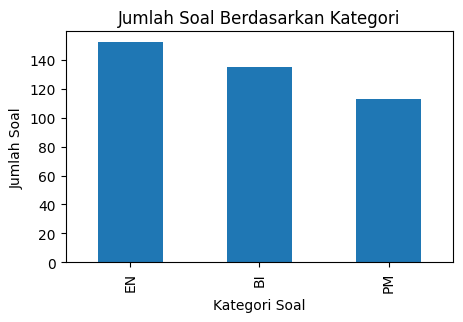

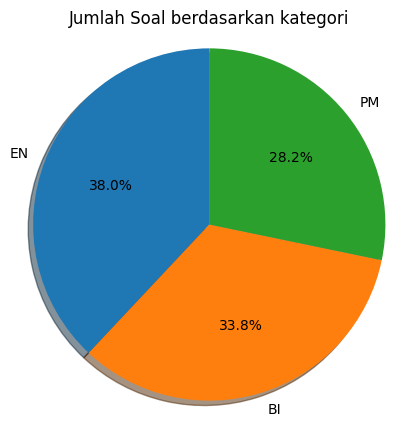

In [7]:
# Visualisasi jumlah soal berdasarkan kategori
plt.figure(figsize=(5, 3))
literasi_question_data['Question_Category'].value_counts().plot(kind='bar')
plt.title('Jumlah Soal Berdasarkan Kategori')
plt.xlabel('Kategori Soal')
plt.ylabel('Jumlah Soal')
plt.show()

# Membuat pie chart
sizes = literasi_question_data['Question_Category'].value_counts()
labels=sizes.index

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Jumlah Soal berdasarkan kategori')
plt.axis('equal')
plt.show()


## Building Recommender System

In [8]:
# Menghitung jumlah soal yang telah dijawab oleh user untuk setiap kategori
def get_total_questions_per_category(user_data):
    return user_data.groupby('Question_Category').size()

# Menghitung jumlah soal yang salah dijawab oleh user untuk setiap kategori
def get_mistakes_per_category(user_data):
    mistakes = user_data[user_data['USER_ANSWER'] != user_data['CORRECT_ANSWER']]
    return mistakes.groupby('Question_Category').size(), mistakes

In [9]:
# Menghitung similarity antara soal yang salah dijawab dengan soal lain dalam kategori yang sama
def calculate_similarity(mistakes, literasi_question_data_filtered):
    combined_descriptions = pd.concat([mistakes['Question_Description'], literasi_question_data_filtered['Questions_Descriptions']])

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_descriptions)

    # Pisahkan TF-IDF matrix untuk user_mistakes dan literasi_question_data
    tfidf_user_mistakes = tfidf_matrix[:len(mistakes)]
    tfidf_literasi_question_data = tfidf_matrix[len(mistakes):]

    # Hitung cosine similarity
    similarity_matrix = cosine_similarity(tfidf_user_mistakes, tfidf_literasi_question_data)

    # Menampilkan similarity matrix dalam bentuk DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, columns=literasi_question_data_filtered.index)
    similarity_df.index = mistakes['ID_QUESTION'].values

    # Filter similarity berdasarkan kategori yang sama
    top_similar_questions = {}
    for idx, user_question in enumerate(similarity_df.index):
        category = mistakes.iloc[idx]['Question_Category']
        same_category_indices = literasi_question_data_filtered[literasi_question_data_filtered['Question_Category'] == category].index
        category_similarities = similarity_df.loc[user_question, same_category_indices]
        top_similar_questions[user_question] = category_similarities.nlargest(10) # mengambil top 10 yang paling mirip

    return top_similar_questions

In [10]:
# Menentukan proporsi soal berdasarkan kategori yang salah dijawab lebih banyak
def determine_proportion(mistakes_per_category, total_questions=10, min_questions_per_category=1):
   # Kategori yang ada
    all_categories = user_data['Question_Category'].unique()

    # Proporsi minimal untuk setiap kategori
    proportion = pd.Series(min_questions_per_category, index=all_categories)

    # Soal yang tersisa setelah distribusi minimal
    remaining_questions = total_questions - proportion.sum()

    # Proporsi berdasarkan kesalahan
    if remaining_questions > 0:
        mistakes_proportion = (mistakes_per_category / mistakes_per_category.sum() * remaining_questions).round().astype(int)
        for cat in mistakes_proportion.index:
            proportion[cat] += mistakes_proportion[cat]

    # Jika masih ada sisa soal yang belum terdistribusi, tambahkan ke kategori dengan kesalahan terbanyak
    remaining_questions = total_questions - proportion.sum()
    if remaining_questions > 0:
        most_mistakes_category = mistakes_per_category.idxmax()
        proportion[most_mistakes_category] += remaining_questions

    return proportion

In [11]:
# Menyusun kuis berdasarkan proporsi dan soal-soal dengan similarity tertinggi
def generate_quiz(proportion, top_similar_questions, mistakes, literasi_question_data_filtered, total_questions=10):
    quiz_questions = []

    # Soal yang salah dijawab berdasarkan similarity
    for category in proportion.index:
        questions_needed = proportion[category]
        if category in mistakes['Question_Category'].values:
            for user_question, similar_questions in top_similar_questions.items():
                if mistakes.loc[mistakes['ID_QUESTION'] == user_question]['Question_Category'].values[0] == category:
                    similar_question_ids = [literasi_question_data_filtered.loc[idx]['ID'] for idx in similar_questions.index]
                    selected_questions = literasi_question_data_filtered[literasi_question_data_filtered['ID'].isin(similar_question_ids) &
                                                                       (literasi_question_data_filtered['Question_Category'] == category)].head(questions_needed).to_dict('records')
                    quiz_questions.extend(selected_questions)
                    break

    # Soal yang dijawab benar secara acak
    for category in proportion.index:
        if category not in mistakes['Question_Category'].values:
            questions_needed = proportion[category]
            selected_questions = literasi_question_data_filtered[literasi_question_data_filtered['Question_Category'] == category].sample(questions_needed).to_dict('records')
            quiz_questions.extend(selected_questions)

    # Pastikan hanya ada 10 soal
    quiz_questions = quiz_questions[:total_questions]
    return quiz_questions

In [12]:
# Memeriksa apakah user baru
def is_new_user(user_id, user_history):
    return user_history[user_history['ID_USER'] == user_id].empty

# Menghasilkan soal untuk user baru secara merata per kategori
def generate_questions_for_new_user(literasi_question_data, total_questions=10):
    categories = literasi_question_data['Question_Category'].unique()
    questions_per_category = total_questions // len(categories)

    quiz_questions = []

    for category in categories:
        selected_questions = literasi_question_data[literasi_question_data['Question_Category'] == category].sample(questions_per_category).to_dict('records')
        quiz_questions.extend(selected_questions)

    # Jika ada sisa soal yang belum terdistribusi
    remaining_questions = total_questions - len(quiz_questions)
    if remaining_questions > 0:
        extra_questions = literasi_question_data[~literasi_question_data['ID'].isin([q['ID'] for q in quiz_questions])].sample(remaining_questions).to_dict('records')
        quiz_questions.extend(extra_questions)

    return quiz_questions

In [13]:
# Memfilter soal yang sudah dijawab oleh user sebelumnya
def filter_answered_questions(user_data, literasi_question_data):
    answered_question_ids = user_data['ID_QUESTION'].unique()
    return literasi_question_data[~literasi_question_data['ID'].isin(answered_question_ids)]

In [14]:
# Menyusun kuis sambil menghindari pengulangan soal berturut-turut
def generate_quiz_avoiding_repeats(proportion, top_similar_questions, mistakes, literasi_question_data_filtered, last_questions, total_questions=10):
    quiz_questions = []
    used_questions = set(last_questions)  # Set untuk menyimpan soal yang sudah digunakan dalam kuis sebelumnya

    # Soal yang salah dijawab berdasarkan similarity
    for category in mistakes_per_category.index:
        questions_needed = proportion[category]
        for user_question, similar_questions in top_similar_questions.items():
            if mistakes.loc[mistakes['ID_QUESTION'] == user_question]['Question_Category'].values[0] == category:
                 similar_question_ids = [literasi_question_data_filtered.loc[idx]['ID'] for idx in similar_questions.index]
                 selected_questions = literasi_question_data_filtered[literasi_question_data_filtered['ID'].isin(similar_question_ids) &
                                                                     (literasi_question_data_filtered['Question_Category'] == category) &
                                                                     (~literasi_question_data_filtered['ID'].isin(used_questions))].head(questions_needed).to_dict('records')
                 quiz_questions.extend(selected_questions)
                 used_questions.update([q['ID'] for q in selected_questions])
                 break

    # Soal yang dijawab benar secara acak
    for category in proportion.index:
        if category not in mistakes_per_category.index:
            questions_needed = proportion[category]
            selected_questions = literasi_question_data_filtered[literasi_question_data_filtered['Question_Category'] == category].sample(questions_needed).to_dict('records')
            quiz_questions.extend(selected_questions)

    # Pastikan hanya ada 10 soal
    quiz_questions = quiz_questions[:total_questions]
    return quiz_questions

In [52]:
# Merekomendasikan soal kepada user
def recommend_questions_for_user(user_id, user_history, literasi_question_data, last_questions, total_questions=10):
    if is_new_user(user_id, user_history):
        print("User baru, generate soal secara merata per kategori.")
        quiz_questions = generate_questions_for_new_user(literasi_question_data, total_questions)

    else:
        user_data = user_history[user_history['ID_USER'] == user_id]

        # Cek jika semua soal sudah pernah dijawab oleh user
        if len(user_data['ID_QUESTION'].unique()) == len(literasi_question_data):
            literasi_question_data_filtered = literasi_question_data.copy()
        else:
            literasi_question_data_filtered = filter_answered_questions(user_data, literasi_question_data)

        total_questions_per_category = get_total_questions_per_category(user_data)

        mistakes_per_category, mistakes = get_mistakes_per_category(user_data)

        top_similar_questions = calculate_similarity(mistakes, literasi_question_data_filtered)

        proportion = determine_proportion(mistakes_per_category, total_questions)
        print("\nProporsi soal yang akan ditampilkan untuk setiap kategori:")
        print(proportion)

        quiz_questions = generate_quiz_avoiding_repeats(proportion, top_similar_questions, mistakes, literasi_question_data_filtered, last_questions, total_questions)

    # Membuat DataFrame dari quiz_questions
    quiz_df = pd.DataFrame(quiz_questions)
    print("\nSoal yang akan ditampilkan dalam kuis:")
    display(quiz_df)

    return [q['ID'] for q in quiz_questions]  # Mengembalikan ID soal yang digunakan dalam kuis

## Model Implementation

In [54]:
# Menentukan ID user
user_id = 3
last_questions = []
user_data = user_history[user_history['ID_USER'] == user_id]

# Menghitung jumlah soal untuk setiap kategori yang telah dijawab oleh user (untuk pengecekan)
total_questions_per_category = get_total_questions_per_category(user_data)
print("Jumlah soal untuk setiap kategori yang telah dijawab oleh user:")
display(total_questions_per_category)

# Menghitung jumlah soal yang salah dijawab oleh user untuk setiap kategori (untuk pengecekan)
mistakes_per_category, mistakes = get_mistakes_per_category(user_data)
print("\nJumlah soal yang salah dijawab oleh user untuk setiap kategori:")
display(mistakes_per_category)

# Menampilkan soal yang salah dijawab user dalam bentuk tabel
print("\nSoal yang salah dijawab oleh user:")
mistakes_table = mistakes[['ID_QUESTION', 'Question_Category', 'Question_Description']]
display(mistakes_table)

# Mengupdate last_questions menjadi set soal yang di berikan ke user
last_questions = recommend_questions_for_user(user_id, user_history, literasi_question_data, last_questions)

Jumlah soal untuk setiap kategori yang telah dijawab oleh user:


Question_Category
BI    3
EN    5
PM    2
dtype: int64


Jumlah soal yang salah dijawab oleh user untuk setiap kategori:


Question_Category
EN    5
PM    1
dtype: int64


Soal yang salah dijawab oleh user:


,ID_QUESTION,Question_Category,Question_Description
21,846,EN,A Food Delivery App That Guarantees a Living W...
22,900,PM,Dua orang karyawan swasta mendaftar sebagai pe...
23,821,EN,"Recently, there has been a slow uphill battle ..."
25,824,EN,The invention of the internet has revolutioniz...
27,865,EN,"Tetris, one of the world's most popular games ..."
28,841,EN,A Food Delivery App That Guarantees a Living W...



Proporsi soal yang akan ditampilkan untuk setiap kategori:
BI    1
EN    7
PM    2
dtype: int64

Soal yang akan ditampilkan dalam kuis:


,ID,Question_Category,Questions_Descriptions,Choice_1,Choice_2,Choice_3,Choice_4,Right_Answer
0,839,EN,A Food Delivery App That Guarantees a Living W...,Concerned,Informative,Criticize,Supportive,3
1,840,EN,A Food Delivery App That Guarantees a Living W...,Employee workload at Wings is directly correla...,There is fierce corporate competition among fo...,Wings can ensure the survival of its employees...,Large food delivery service providers are losi...,2
2,842,EN,A Food Delivery App That Guarantees a Living W...,Teachers and students,Ministries and president,Freelancer and company,Farmers and his field,2
3,843,EN,A Food Delivery App That Guarantees a Living W...,Wings is a corporative-style business,Wings is against providing workers insufficien...,Workers at Wings who deliver food are also Coo...,Wings has thousands of employees in Paris,1
4,844,EN,A Food Delivery App That Guarantees a Living W...,London’s most profitable business is DoorDash,Large expenses don’t always result in large pr...,Large apps can create more money than cooperat...,"Due to increased demand during the pandemic, W...",3
5,845,EN,A Food Delivery App That Guarantees a Living W...,One such food delivery service operating profi...,"Wings, Deliverioo, and Uber Eats are used by b...",Largest food delivery business in the United S...,One of the biggest delivery firms still affect...,3
6,847,EN,A Food Delivery App That Guarantees a Living W...,Flooding and deforestation,Restaurant and chef,Watermelons and fruits,Advertising and demand,3
7,889,PM,Diketahui pada suatu seleksi calon karyawan te...,"1, 2, dan 3 SAJA yang benar.",1 dan 3 SAJA yang benar.,2 dan 4 SAJA yang benar.,HANYA 4 yang benar.,3
8,899,PM,Dua orang karyawan swasta mendaftar sebagai pe...,"Rp5.000.000,00","Rp5.500.000,00","Rp4.500.000,00","Rp4.000.000,00",3
9,655,BI,Para ilmuwan dibuat bingung oleh perbedaan yan...,Itu akan menjadi masalah yang lebih serius di ...,Ini tidak mungkin menjadi masalah serius di ma...,Ini akan berlangsung pada tingkat umum yang sa...,"Sampai akhir 1980-an, di belahan bumi utara di...",3
